In [1]:
# to handle paths
import sys
import os
from pathlib import Path

# to handle datasets
import pandas as pd
import numpy as np
from natsort import natsorted

# for iterating
from itertools import product

# for calculating similarity
from scipy.spatial.distance import cosine

# for calculating perfromance 
from sklearn.metrics import mean_absolute_error, median_absolute_error

# for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

# for saving
import joblib

# to visualise the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# variables
project_name = "RF+Clust"
project_folder = f"C:/Users/anani/Downloads/{project_name}"
sys.path.append(project_folder)

from variables import suite_name, features, target, transformation, n_folds, budgets, algorithms
from variables import model_name, explainer_type
from variables import logscale, vmax
from rf_clus import RF_clus
from variables import metric, calibration_method, similarity_thresholds, weights_method

In [3]:
# define directories
if features != "all":
    data_folder = f"{project_folder}/Data/{suite_name}/preprocessed/transformation={transformation}_features={features}/{model_name}"
else: 
    data_folder = f"{project_folder}/Data/{suite_name}/preprocessed/transformation={transformation}_features={features}"

results_folder = f"{project_folder}/Results/{suite_name}/transformation={transformation}_features={features}/{model_name}"

In [4]:
def mae(df, col_name):
    """
    Function to calculate MAE.
    """
    mae = mean_absolute_error(df['true'].values, df['predicted'].values)

    return pd.Series({col_name: mae})

In [5]:
def mdae(df, col_name):
    """
    Function to calculate MAE.
    """
    mdae = median_absolute_error(df['true'].values, df['predicted'].values)

    return pd.Series({col_name: mdae})

In [6]:
def read_fold_data(directory: str, fold_number: int): 
    """
    Read X_train, y_test, X_test, y_test from csv file.
    """
    X_train = pd.read_csv(f"{directory}/X_train_fold={fold_number}.csv"
                         , index_col=["f_id", "i_id"], dtype={"f_id": int, "i_id": int})

    X_test = pd.read_csv(f"{directory}/X_test_fold={fold_number}.csv"
                         , index_col=["f_id", "i_id"], dtype={"f_id": int, "i_id": int})

    y_train = pd.read_csv(f"{directory}/y_train_fold={fold_number}.csv"
                          , index_col=["f_id", "i_id"], dtype={"f_id": int, "i_id": int})

    y_test = pd.read_csv(f"{directory}/y_test_fold={fold_number}.csv"
                        , index_col=["f_id", "i_id"], dtype={"f_id": int, "i_id": int})

    return X_train, y_train, X_test, y_test

## RF+Clus

In [9]:
for algorithm_name, budget in product(algorithms, budgets):
    print(f"algorithm_name: {algorithm_name}")
    print(f"budget: {budget}")
    
    # define directories
    data_folder_temp = f"{data_folder}/algorithm_name={algorithm_name}_budget={budget}"
    results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"
    
    # create directories
    os.makedirs(f"{results_folder_temp}/rfclust", exist_ok=True)

    # create results placeholders
    predictions_rfclus = pd.DataFrame()
    mask = pd.DataFrame()
    similar_instances = pd.DataFrame()
    similarity = pd.DataFrame()

    # file title
    title = f"metric={metric}_method={calibration_method}_weights={weights_method}"

    for fold_number in np.arange(1, n_folds+1):
        print(f"fold_number: {fold_number}")
        
        # load data
        X_train, y_train, X_test, y_test = read_fold_data(directory=data_folder_temp, fold_number=fold_number) 

        # load trained model
        model = joblib.load(f"{results_folder_temp}/models/model_fold={fold_number}.joblib")

        # load predictions 
        predictions_rf_temp = pd.read_csv(f"{results_folder_temp}/predictions/predictions_set=test_fold={fold_number}.csv")
        predictions_rf_temp["model"] = "RF"
        
        # load weights
        if weights_method == None:
            weights = None
        else:
            weights = pd.read_csv(f"{weights_folder}/weights_method={weights_method}.csv", index_col = "fold_number")

            # weights need to have same order as data features
            weights = weights[X_train.columns]
            # get fold weights
            weights = weights[weights.index.get_level_values(0) == fold_number].values[0]

        print(f"weights: ")
        print(weights)
        
        predictions_rfclus = pd.concat([predictions_rfclus, predictions_rf_temp.reset_index()], axis=0)

        # make predictions with rfclust
        for similarity_threshold in similarity_thresholds:
            
            print(f"similarity_threshold: {similarity_threshold}")

            # init RF_clus
            rf_clus = RF_clus(base_estimator=model
                              , metric=metric
                              , similarity_threshold=similarity_threshold
                              , method=calibration_method
                              , weights=weights
                              )
            # fit on train
            rf_clus.fit(X_train, y_train[target])

            # predict
            predictions_rfclus_temp, mask_temp, similarity_temp, similar_instances_temp = rf_clus.predict_rf_clus(X_test=X_test
                                                                                , y_test=y_test[target])

            predictions_rfclus_temp["model"] = similarity_threshold
            mask_temp["model"] = similarity_threshold
            similar_instances_temp["model"] = similarity_threshold

            # concat results for all folds
            predictions_rfclus = pd.concat([predictions_rfclus, predictions_rfclus_temp], axis=0)
            mask = pd.concat([mask, mask_temp], axis=0)
            similar_instances = pd.concat([similar_instances, similar_instances_temp], axis=0)
            similarity = pd.concat([similarity, similarity_temp], axis=0)    


    # save rf predictions
    predictions_rfclus.to_csv(f"{results_folder_temp}/rfclust/predictions_{title}.csv", index=False)

    print(f"predictions rfclus: ")
    print(predictions_rfclus.head(50))

    # calculate model perfromance
#             perfromance_rfclus["mae"] = predictions_rfclus.groupby("model").apply(mae, ("mae"))
#             perfromance_rfclus["mdae"] = predictions_rfclus.groupby("model").apply(mdae, ("mdae"))
#             print(f"perfromance_rfclus:  ")
#             print(perfromance_rfclus)            


    # compare models AE error
    # calculate the prediction error
    compare_predictions = predictions_rfclus.copy()
    compare_predictions["AE"] = abs(compare_predictions["true"] - compare_predictions["predicted"])
    
    # transform to pivot
    if suite_name == "bbob":
        compare_predictions["f_id"] = compare_predictions["f_id"].astype(str) + "_" + compare_predictions["i_id"].astype(str) 
    else:
        compare_predictions["f_id"] = compare_predictions["f_id"].astype(str)

    compare_predictions = compare_predictions.drop("i_id", axis=1)
    compare_predictions = compare_predictions.pivot(index=["model"], columns=["f_id"]
                                                          , values="AE")
    # sort rows and columns
    compare_predictions = compare_predictions.reindex(["RF"] + [0.9, 0.7, 0.5])
    compare_predictions = compare_predictions.reindex(natsorted(compare_predictions.columns), axis=1)
    print("compare_predictions: ")
    print(compare_predictions)


    # mask        
    compare_mask = mask.copy()
    if suite_name == "bbob":
        compare_mask["f_id"] = compare_mask["f_id"].astype(str) + "_" + compare_mask["i_id"].astype(str) 
    else:
        compare_mask["f_id"] = compare_mask["f_id"].astype(str) 

    compare_mask = compare_mask.pivot(index=["model"], columns=["f_id"], values="predicted")
    # add row RF 
    compare_mask.loc["RF"] = False
    compare_mask = compare_mask.reindex(["RF"] + [0.9, 0.7, 0.5])
    compare_mask = compare_mask.reindex(natsorted(compare_mask.columns), axis=1)
    print("compare_mask: ")
    print(compare_mask)


    # similar insatnces
    compare_similar_instances = similar_instances.copy()
    if suite_name == "bbob":
        compare_similar_instances["f_id"] = compare_similar_instances["f_id"].astype(str) + "_" + compare_similar_instances["i_id"].astype(str) 
    else:
        compare_similar_instances["f_id"] = compare_similar_instances["f_id"].astype(str)

    compare_similar_instances = compare_similar_instances.pivot(index=["model"], columns=["f_id"], values="n_similar")  
    compare_similar_instances.loc["RF"] = " "
    compare_similar_instances = compare_similar_instances.reindex(natsorted(compare_similar_instances.columns), axis=1)
    compare_similar_instances = compare_similar_instances.reindex(["RF"] + [0.9, 0.7, 0.5])

    print("compare_similar_instances: ")
    print(compare_similar_instances)


    # similarity
    similarity = similarity.drop_duplicates()

    if suite_name != "bbob":
        similarity.columns = [str(col[0]) for col in similarity.columns]
        similarity = similarity.drop("i_id", axis=1)
    else: 
        similarity["f_id"] = similarity["f_id"].astype(str) + "_" + similarity["i_id"].astype(str) 
        similarity.columns = [str(col[0]) +  + "_" + col[1] for col in similarity.columns]

    print("similarity: ")
    print(similarity)
    print(similarity.shape)

    # save
#             perfromance_rfclus.reset_index().to_csv(f"{weights_folder}/perfromance_{title}.csv", index=False)
    compare_predictions.reset_index().to_csv(f"{results_folder_temp}/rfclust/ae_{title}.csv", index=False)
    compare_mask.reset_index().to_csv(f"{results_folder_temp}/rfclust/mask_{title}.csv", index=False)
    compare_similar_instances.reset_index().to_csv(f"{results_folder_temp}/rfclust/n_similar_{title}.csv", index=False)
    similar_instances.reset_index().to_csv(f"{results_folder_temp}/rfclust/similar_inst_{title}.csv", index=False)
    similarity.to_csv(f"{results_folder_temp}/rfclust/similarity_metric={metric}_weights={weights_method}.csv", index=False)

algorithm_name: DE1
budget: 5000
fold_number: 1
weights: 
None
similarity_threshold: 0.9
Calculating similarity of test instances with train instances.
metric: cosine
weights: None
Test instance: (1, 1)
Similar instances:
[]
0
f_id  i_id
2     1       0.350648
3     1       0.231432
4     1       0.410653
5     1      -0.569528
6     1      -0.698991
7     1       0.355225
8     1      -0.093454
9     1      -0.151571
10    1      -0.523817
11    1      -0.521775
12    1      -0.570228
13    1       0.319764
14    1       0.114035
15    1      -0.063842
16    1      -0.659094
17    1       0.173767
18    1       0.018040
19    1       0.510746
20    1       0.328215
21    1       0.450013
22    1       0.136802
23    1       0.504398
24    1       0.072265
25    1      -0.146171
26    1      -0.145089
27    1       0.133986
28    1      -0.093474
29    1       0.103893
30    1       0.458978
Name: (1, 1), dtype: float64
Cosine similarity: 
f_id f_id i_id         2         3         4  

similarity_threshold: 0.5
Calculating similarity of test instances with train instances.
metric: cosine
weights: None
Test instance: (3, 1)
Similar instances:
[(17, 1), (20, 1), (25, 1)]
3
f_id  i_id
1     1       0.248583
2     1      -0.318424
4     1      -0.409551
5     1       0.108208
6     1      -0.097299
7     1      -0.565689
8     1      -0.747727
9     1      -0.676239
10    1       0.171285
11    1       0.113647
12    1       0.126736
13    1      -0.613172
14    1      -0.596528
15    1      -0.302092
16    1       0.033742
17    1       0.937642
18    1       0.429927
19    1       0.018284
20    1       0.843031
21    1       0.388320
22    1       0.307982
23    1      -0.230205
24    1      -0.525218
25    1       0.522945
26    1      -0.325953
27    1      -0.061502
28    1       0.222621
29    1       0.273294
30    1       0.292008
Name: (3, 1), dtype: float64
ms: (17, 1)
ms value: 4.36769196850744
ms weight: 0.9376421845258301
ms: (20, 1)
ms value: 1.49168097627

Test instance: (6, 1)
Similar instances:
[(5, 1), (12, 1), (16, 1)]
3
f_id  i_id
1     1      -0.709978
2     1      -0.422840
3     1      -0.114121
4     1      -0.598518
5     1       0.932777
7     1      -0.518781
8     1       0.059624
9     1       0.100981
10    1       0.838171
11    1       0.840502
12    1       0.926552
13    1      -0.400408
14    1      -0.234935
15    1      -0.264836
16    1       0.937537
17    1      -0.164027
18    1       0.060855
19    1      -0.572799
20    1      -0.198596
21    1      -0.430158
22    1      -0.306843
23    1      -0.457123
24    1      -0.352746
25    1       0.169777
26    1      -0.041395
27    1      -0.254699
28    1       0.133931
29    1      -0.074840
30    1      -0.343992
Name: (6, 1), dtype: float64
ms: (5, 1)
ms value: 1.3296543136165155
ms weight: 0.9327774748284512
ms: (12, 1)
ms value: 0.299819588930029
ms weight: 0.9265516509233933
ms: (16, 1)
ms value: 0.678422968713823
ms weight: 0.937537353223021
Cosine similar

weights: 
None
similarity_threshold: 0.9
Calculating similarity of test instances with train instances.
metric: cosine
weights: None
Test instance: (9, 1)
Similar instances:
[(8, 1)]
1
f_id  i_id
1     1      -0.160173
2     1       0.342145
3     1      -0.697592
4     1       0.570638
5     1      -0.239609
6     1       0.079000
7     1       0.671560
8     1       0.916047
10    1      -0.397906
11    1      -0.320841
12    1      -0.254727
13    1       0.739742
14    1       0.886820
15    1       0.466459
16    1      -0.135696
17    1      -0.525115
18    1      -0.262836
19    1      -0.072853
20    1      -0.612728
21    1      -0.426881
22    1      -0.272760
23    1       0.539235
24    1       0.716859
25    1       0.030751
26    1       0.228707
27    1      -0.026501
28    1      -0.436546
29    1      -0.620676
30    1      -0.427903
Name: (9, 1), dtype: float64
ms: (8, 1)
ms value: 1.503573023876318
ms weight: 0.9160470546992763
Cosine similarity: 
f_id f_id i_id     

similarity_threshold: 0.7
Calculating similarity of test instances with train instances.
metric: cosine
weights: None
Test instance: (11, 1)
Similar instances:
[(5, 1), (6, 1), (10, 1), (12, 1), (16, 1)]
5
f_id  i_id
1     1      -0.519962
2     1      -0.465972
3     1       0.121959
4     1      -0.686448
5     1       0.935841
6     1       0.854128
7     1      -0.716758
8     1      -0.281368
9     1      -0.281977
10    1       0.986834
12    1       0.935072
13    1      -0.699569
14    1      -0.613032
15    1      -0.392479
16    1       0.868274
17    1       0.018418
18    1       0.166124
19    1      -0.464659
20    1       0.027761
21    1      -0.256570
22    1      -0.225477
23    1      -0.495932
24    1      -0.497726
25    1       0.051489
26    1      -0.069896
27    1      -0.081740
28    1       0.283266
29    1       0.157370
30    1      -0.052816
Name: (11, 1), dtype: float64
ms: (5, 1)
ms value: 1.3296543136165155
ms weight: 0.9358408925064587
ms: (6, 1)
ms va

Test instance: (13, 1)
Similar instances:
[(4, 1), (7, 1), (8, 1), (9, 1), (14, 1)]
5
f_id  i_id
1     1       0.320704
2     1       0.472832
3     1      -0.628508
4     1       0.833074
5     1      -0.603270
6     1      -0.396264
7     1       0.951227
8     1       0.782100
9     1       0.744740
10    1      -0.736808
11    1      -0.705842
12    1      -0.630287
14    1       0.896549
15    1       0.366137
16    1      -0.529085
17    1      -0.485577
18    1      -0.426836
19    1       0.361224
20    1      -0.514177
21    1      -0.136429
22    1      -0.153474
23    1       0.589809
24    1       0.637643
25    1      -0.151500
26    1       0.432927
27    1       0.286535
28    1      -0.377517
29    1      -0.184783
30    1      -0.116560
Name: (13, 1), dtype: float64
ms: (4, 1)
ms value: 1.5747836546184113
ms weight: 0.8330742381244851
ms: (7, 1)
ms value: 0.3063220950801281
ms weight: 0.9512272775376508
ms: (8, 1)
ms value: 1.503573023876318
ms weight: 0.78209976180395

f_id f_id i_id         1        2         3         4         5        6  \
i_id                   1        1         1         1         1        1   
0      15    1 -0.057773  0.33828 -0.305197  0.500548 -0.495742 -0.28262   

f_id         7         8         9        10        11        12        13  \
i_id         1         1         1         1         1         1         1   
0     0.392876  0.389197  0.463711 -0.451563 -0.423369 -0.471938  0.346457   

f_id        14        16        17        18        19       20        21  \
i_id         1         1         1         1         1        1         1   
0     0.544838 -0.276398 -0.138303  0.133618  0.127041 -0.22022 -0.087945   

f_id        22        23        24       25        26        27        28  \
i_id         1         1         1        1         1         1         1   
0     0.465156  0.394058  0.634048 -0.06659  0.283547 -0.097777 -0.280564   

f_id        29        30  
i_id         1         1  
0    -0.509168 -0.

Test instance: (18, 1)
Similar instances:
[]
0
f_id  i_id
1     1       0.028904
2     1       0.025728
3     1       0.394980
4     1      -0.261773
5     1       0.038994
6     1       0.034085
7     1      -0.387557
8     1      -0.330575
9     1      -0.279971
10    1       0.149525
11    1       0.120842
12    1       0.066515
13    1      -0.452643
14    1      -0.280501
15    1       0.123946
16    1       0.040163
17    1       0.337916
19    1       0.107650
20    1       0.362137
21    1       0.262588
22    1       0.327703
23    1      -0.144526
24    1      -0.255194
25    1       0.244850
26    1      -0.271410
27    1      -0.359058
28    1      -0.028819
29    1      -0.008826
30    1      -0.120345
Name: (18, 1), dtype: float64
Cosine similarity: 
f_id f_id i_id         1         2        3         4         5         6  \
i_id                   1         1        1         1         1         1   
0      18    1  0.028904  0.025728  0.39498 -0.261773  0.038994  0.0340

Test instance: (21, 1)
Similar instances:
[(30, 1)]
1
f_id  i_id
1     1       0.436193
2     1       0.084778
3     1       0.401375
4     1      -0.076962
5     1      -0.285052
6     1      -0.425989
7     1      -0.053397
8     1      -0.276528
9     1      -0.354881
10    1      -0.233144
11    1      -0.280710
12    1      -0.274745
13    1      -0.107513
14    1      -0.151943
15    1      -0.055701
16    1      -0.342439
17    1       0.270943
18    1       0.273305
19    1       0.265913
20    1       0.301471
22    1       0.250297
23    1       0.079296
24    1       0.036733
25    1       0.182729
26    1      -0.262005
27    1      -0.200376
28    1       0.079187
29    1       0.326248
30    1       0.577856
Name: (21, 1), dtype: float64
ms: (30, 1)
ms value: 3.3512968272173733
ms weight: 0.5778561217483249
Cosine similarity: 
f_id f_id i_id         1         2         3         4         5         6  \
i_id                   1         1         1         1         1     

Test instance: (24, 1)
Similar instances:
[(9, 1), (14, 1), (23, 1)]
3
f_id  i_id
1     1       0.088704
2     1       0.405932
3     1      -0.539844
4     1       0.641457
5     1      -0.608020
6     1      -0.364669
7     1       0.646454
8     1       0.629554
9     1       0.725930
10    1      -0.595053
11    1      -0.507301
12    1      -0.620716
13    1       0.628172
14    1       0.731051
15    1       0.631805
16    1      -0.543484
17    1      -0.371627
18    1      -0.238012
19    1       0.146848
20    1      -0.477485
21    1      -0.051888
22    1       0.007480
23    1       0.785091
25    1       0.046226
26    1       0.201141
27    1       0.140647
28    1      -0.270375
29    1      -0.439486
30    1       0.049648
Name: (24, 1), dtype: float64
ms: (9, 1)
ms value: 1.758035885209552
ms weight: 0.725929950297112
ms: (14, 1)
ms value: 0.1482593642036202
ms weight: 0.7310513247055859
ms: (23, 1)
ms value: 2.3923631152851392
ms weight: 0.7850908064935653
Cosine simi

Test instance: (27, 1)
Similar instances:
[]
0
f_id  i_id
1     1       0.115032
2     1      -0.049093
3     1      -0.102005
4     1       0.456600
5     1      -0.206138
6     1      -0.274223
7     1       0.319434
8     1      -0.040130
9     1      -0.029797
10    1      -0.157405
11    1      -0.112292
12    1      -0.218127
13    1       0.267179
14    1      -0.013918
15    1      -0.152029
16    1      -0.299567
17    1      -0.093440
18    1      -0.370759
19    1       0.312697
20    1      -0.131126
21    1      -0.219470
22    1      -0.053456
23    1       0.001324
24    1       0.103274
25    1      -0.098629
26    1       0.651608
28    1       0.119928
29    1       0.474068
30    1       0.221527
Name: (27, 1), dtype: float64
Cosine similarity: 
f_id f_id i_id         1         2         3       4         5         6  \
i_id                   1         1         1       1         1         1   
0      27    1  0.115032 -0.049093 -0.102005  0.4566 -0.206138 -0.274223 

weights: 
None
similarity_threshold: 0.9
Calculating similarity of test instances with train instances.
metric: cosine
weights: None
Test instance: (30, 1)
Similar instances:
[]
0
f_id  i_id
1     1       0.452017
2     1      -0.099964
3     1       0.287577
4     1      -0.111082
5     1      -0.173015
6     1      -0.351132
7     1      -0.062116
8     1      -0.284580
9     1      -0.423198
10    1      -0.072003
11    1      -0.080311
12    1      -0.160165
13    1      -0.133668
14    1      -0.348263
15    1      -0.252839
16    1      -0.307712
17    1       0.121983
18    1      -0.120228
19    1       0.209009
20    1       0.155755
21    1       0.579744
22    1       0.092317
23    1       0.158886
24    1       0.039285
25    1      -0.014686
26    1      -0.252835
27    1       0.237839
28    1       0.279963
29    1       0.607501
Name: (30, 1), dtype: float64
Cosine similarity: 
f_id f_id i_id         1         2         3         4         5         6  \
i_id          

## Analysis

In [12]:
def plot_heatmap(data, mask, n_similar, font_scale, figsize, save_path, title, **kwargs):
    """
    Function to plot a costumized heatmap.
    """
    # set up plot
    sns.set_theme(context='notebook', font_scale=font_scale)
    f, axs = plt.subplots(3, 1, figsize=figsize, sharey=False, sharex=False)

    # split f_ids for visualization purposes
    f_id_splits = np.array_split(data.columns.tolist(), 3)
    f_id_splits = [split.tolist() for split in f_id_splits]
    
    # select f_ids
    for i, f_ids in enumerate(f_id_splits):
        print("f_ids: ", f_ids)
             
        data_temp = data[f_ids]  
        mask_temp = mask[f_ids]  
        n_similar_temp = n_similar[f_ids]  
        
        # plot data and mask
        sns.heatmap(data_temp, mask=mask_temp, annot=True, linewidths=3, vmin=0, fmt=''
                    , annot_kws={'va':'bottom', 'rotation': 0}
                    , cbar_kws={'label': 'ae'}, ax = axs[i], **kwargs)
     
        # plot n similar
        sns.heatmap(data_temp, annot=n_similar_temp, mask=mask_temp, linewidths=3, vmin=0, ax = axs[i]
                        , annot_kws={'va':'top', 'rotation': 0}, fmt='', cbar=False, **kwargs)
        
        axs[i].set_ylabel("")
        axs[i].set_ylabel("")
        axs[i].yaxis.set_tick_params(rotation=0)

    f.supxlabel('f_id')
    f.title = (title)
    
    plt.tight_layout()
    plt.savefig(f"{save_path}/{title}.png", bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

In [13]:
def plot_scatter(performance, similarity, logscale, font_scale, figsize, title, results_folder, **kwargs):
    """
    Function to plot a costumized scatterplot.
    """
    # get instances
    instances = similarity.index.tolist()
#     print("Instances: ")
#     print(instances)
    
    # set up figure
    if suite_name == "bbob":
        sns.set_theme(context='notebook', style='whitegrid', font_scale=font_scale)
        f, axs = plt.subplots(8, 3, figsize=figsize, sharey=True, sharex=False, dpi=80)
        
    elif suite_name == "cec2014":
        sns.set_theme(context='notebook', style='whitegrid', font_scale=font_scale)
        f, axs = plt.subplots(10, 3, figsize=figsize, sharey=True, sharex=False, dpi=80)

    k = 0
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
#             print(f"instance: {instances[k]}")        
            
            # get performance of instance of interest
            performance_temp = performance.loc[instances[k], target]
#             print(f"performance: {performance_temp}")

            # get similarity of instance of interest
            instance_similarity = pd.DataFrame(similarity.loc[instances[k]]).reset_index().rename(columns={"index":"f_id"})
            instance_similarity["f_id"] = instance_similarity["f_id"].astype(int)
            instance_similarity = instance_similarity.dropna()
            
            # merge similarity and algorithm performance of other insatnces    
            df_merged = pd.merge(instance_similarity, performance.reset_index(), how='left', on = ['f_id'])
            df_merged = df_merged.rename(columns={instances[k]:'similarity'})
            # calculate differernce in perforamnce with instance of interest
            df_merged['difference'] = abs(df_merged[target] - performance_temp)
          
            # plot
            axs[i][j].scatter(df_merged['similarity'], df_merged['difference'], vmin=0, alpha=0.8, s=100)
            
            # enhance plot
            axs[i][j].set_title(f"f_id={instances[k]}")
            axs[i][j].set_xlim(0.4, 1.05)
#             axs[i][j].set_ylim(0, df_merged['difference'].max())
            axs[i][j].set_xticks([0.5, 0.7, 0.9])
            axs[i][j].set_ylabel("difference in algorithm performance")
            axs[i][j].set_xlabel("similarity")
            axs[i][j].yaxis.set_tick_params(labelbottom=True)

            if logscale:
                axs[i][j].set_yscale('log')
            
            for line in range(0, df_merged.shape[0]):
                axs[i][j].annotate(df_merged['f_id'][line], (df_merged.similarity[line] + 0.01, df_merged.difference[line])) #transform=plt.gca().transAxes

            k = k + 1
    
    plt.tight_layout()
    plt.savefig(f"{results_folder}/{title}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

algorithm_name: DE1
budget: 5000


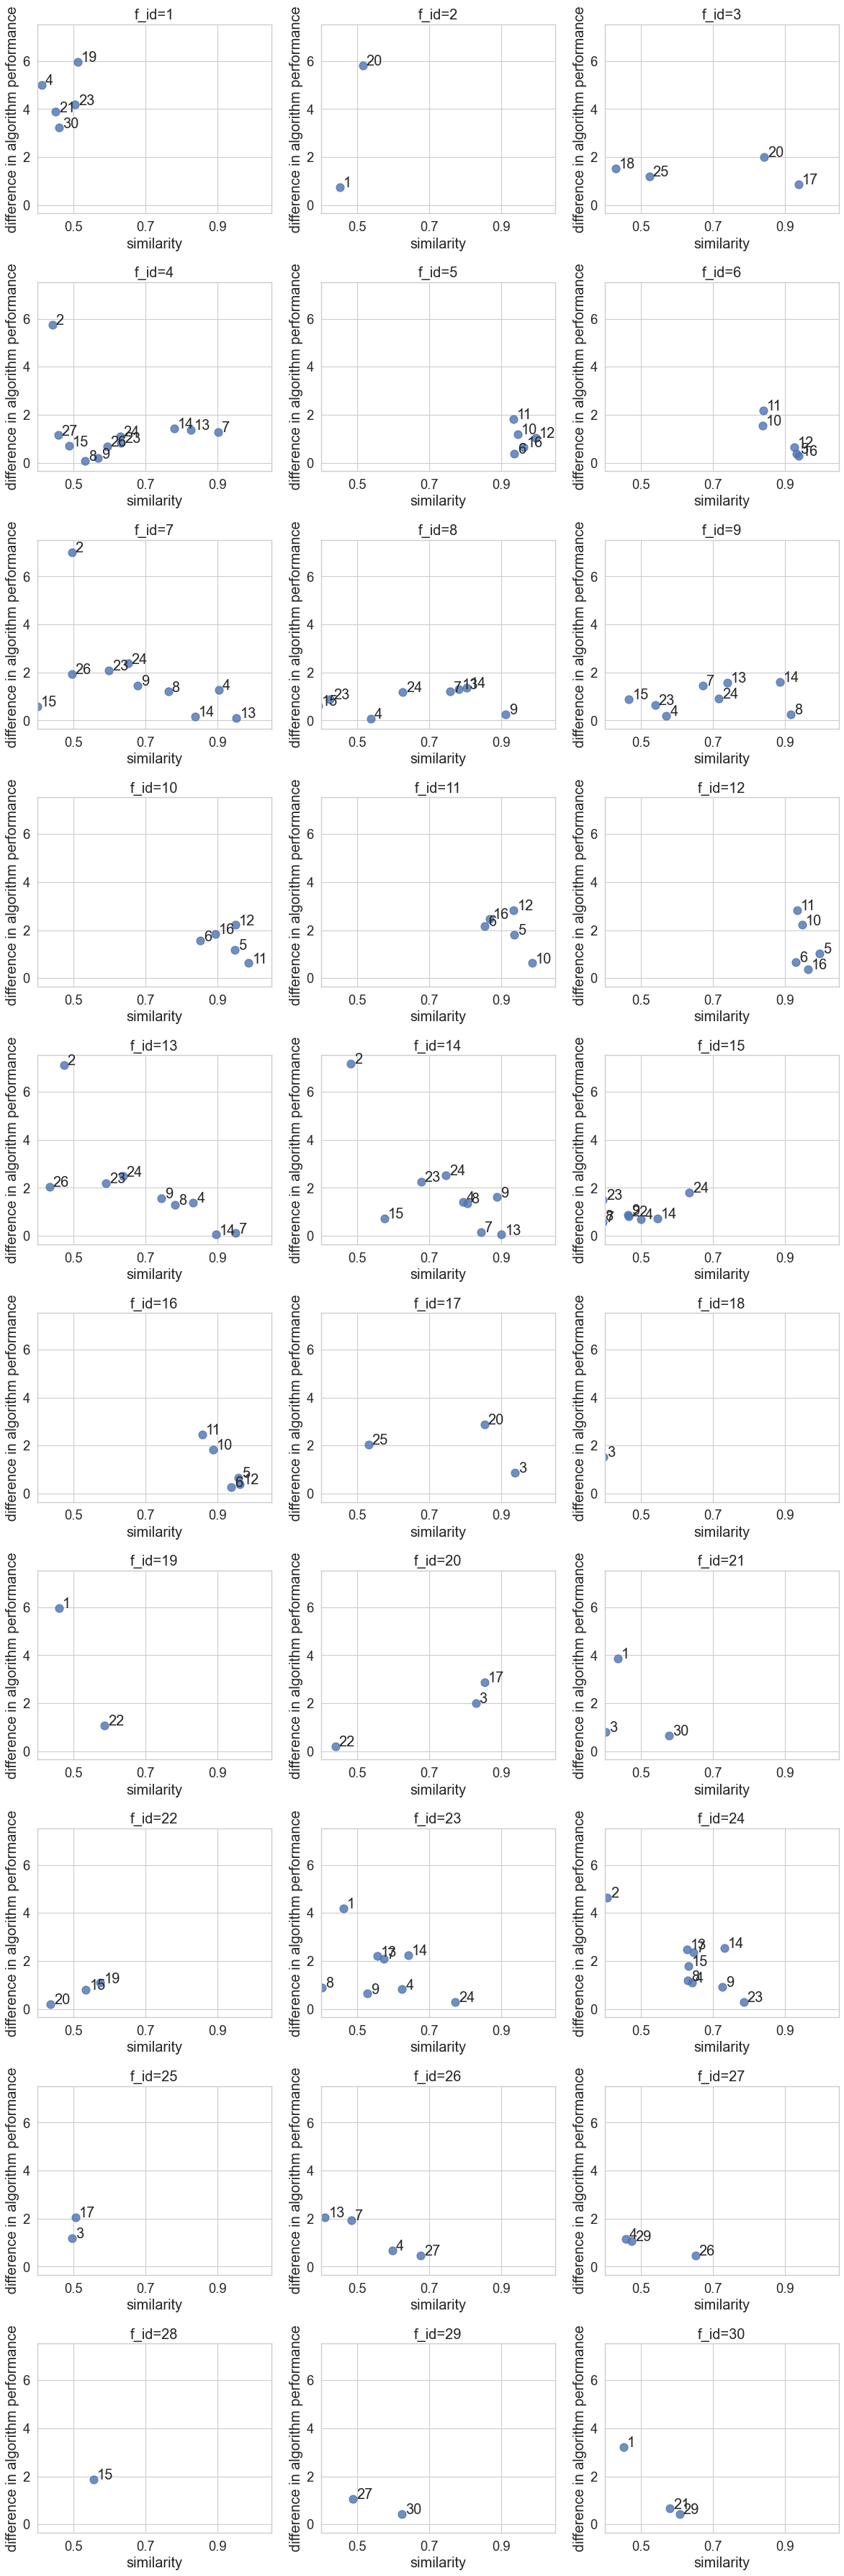

NameError: name 'dsds' is not defined

In [16]:
for algorithm_name, budget in product(algorithms, budgets):
    print(f"algorithm_name: {algorithm_name}")
    print(f"budget: {budget}")

    # define weights directory
    results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"

    # Plot instance similarity vs algorithm performance
    # load algorithm performance
    if suite_name == "bbob":
        performance = pd.read_csv(f"{project_folder}/Data/{suite_name}/original/dataset/algorithm_name={algorithm_name}_budget={budget}_dataset.csv"
                                  , dtype={"f_id":str, "i_id":str})
        performance["f_id"] = performance["f_id"] + "_" + performance["f_id"]
        performance = performance.drop("i_id", axis=1)
        performance = performance.set_index("f_id")
        performance = pd.DataFrame(performance[target])

    else:
        performance = pd.read_csv(f"{project_folder}/Data/{suite_name}/original/dataset/algorithm_name={algorithm_name}_budget={budget}_dataset.csv"
                           , index_col=["f_id"],  dtype={"f_id":int})
        performance = pd.DataFrame(performance[target])

    # load similarity
    similarity = pd.read_csv(f"{results_folder_temp}/rfclust/similarity_metric={metric}_weights={weights_method}.csv"
                                         , index_col = "f_id", dtype={"f_id":int})

    # plot similarity vs different in performance
    plot_scatter(performance=performance, similarity=similarity, logscale=logscale, font_scale=1.5, figsize=(15, 45)
                 ,title=f"sm_vs_{target}_metric={metric}_weights={weights_method}", results_folder=f"{results_folder_temp}/rfclust")

    
    # plot rfclus ae for different thresholds vs rf
    # define title
    title = f"metric={metric}_method={calibration_method}_weights={weights_method}"

    # load ae
    ae = pd.read_csv(f"{weights_folder}/ae_{title}.csv"
                                     , index_col = "model")
    # load mask
    mask = pd.read_csv(f"{weights_folder}/mask_{title}.csv"
                                     , index_col = "model")
    n_similar = pd.read_csv(f"{weights_folder}/n_similar_{title}.csv"
                                     , index_col = "model")

    if suite == "bbob":
        font_scale=1
        figsize=(15, 15)
    else:
        font_scale=1.5
        figsize=(13, 10)


    if logscale:
        plot_heatmap(data=round(ae, 4), mask=mask, n_similar=n_similar, font_scale=font_scale, figsize=figsize
                     , save_path=weights_folder
                     , title=f"compare_models_{title}", cmap="coolwarm", vmax=vmax, norm=LogNorm())
    else:
        plot_heatmap(data=round(ae, 4), mask=mask, n_similar=n_similar,font_scale=font_scale, figsize=figsize
                     , save_path=weights_folder
                     , title=f"comp_models_{title}", cmap="coolwarm", vmax=vmax)


    # times better & mean
    compare_models = pd.DataFrame()
    compare_models.loc["RF", "times_better"] = np.nan

    for idx in [idx for idx in ae.index if idx != 'RF']:
        compare_models.loc[idx, 'times_better'] = int(sum(np.where(ae.loc['RF', :]
                                                                 > ae.loc[idx, :], 1, 0)))    
        compare_models.loc[idx, 'times_equal'] = int(sum(np.where(ae.loc['RF', :]
                                                                 == ae.loc[idx, :], 1, 0)))
        compare_models.loc[idx, 'times_worse'] = int(sum(np.where(ae.loc['RF', :]
                                                                 < ae.loc[idx, :], 1, 0)))

    compare_models["mean"] = ae.mean(axis=1)
    compare_models["median"] = ae.median(axis=1)
    compare_models["calibration_method"] = calibration_method
    compare_models["weights_method"] = weights_method
    compare_models["algorithm_name"] = algorithm_name
    print("model perfromance: ")
    print(compare_models[["algorithm_name", "mean", "median"]].to_latex())


    # plot times better and mean
    sns.set_theme(context='notebook', style='whitegrid', font_scale=1)
    f, ax = plt.subplots(1, 3, figsize=(7, 3), dpi=80)
    bar_width = 0.4

    ax[0].bar(compare_models.index, compare_models["times_better"], bar_width)
    ax[0].set_ylabel("times_better")
    ax[0].xaxis.grid(False)
    ax[1].bar(compare_models.index, compare_models["mean"], bar_width)
    ax[1].set_ylabel("mean")
    ax[1].xaxis.grid(False)
    ax[2].bar(compare_models.index, compare_models["median"], bar_width)
    ax[2].set_ylabel("median")
    ax[2].xaxis.grid(False)

    plt.tight_layout()
    plt.savefig(f"{weights_folder}/performance_{title}.png", bbox_inches='tight', dpi=300)
    plt.show()

    # save
    compare_models.reset_index().to_csv(f"{weights_folder}/performance_{title}.csv", index=False)   